# **ResNet-9 Model**
  https://myrtle.ai/how-to-train-your-resnet-8-bag-of-tricks/

Shows that the top six entries all use 9-layer ResNets,so build a 9-layer ResNets first.

---


## Preparing Work

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### 1) Dataset Preparing

1) Ready dataset

In [20]:
from torchvision import datasets
cifar10 = datasets.CIFAR10(root='../data',download = True)

Files already downloaded and verified


2) Although we get image dataset, we still need to manually transfer those image into a same figure size and do some dispose for a better dataset prepraing

In [21]:
import torchvision
Transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)), #reshape size
    torchvision.transforms.ToTensor(), #change range to (0,1)
    torchvision.transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)), #(Normalization)
])

3) Seperate dataset to trainset and testset

In [22]:
from torch.utils.data import DataLoader
trainset = torchvision.datasets.CIFAR10(root='../data',train=True,transform = Transformer,download=True)
valset = torchvision.datasets.CIFAR10(root='../data',train=False,transform = Transformer,download=True)

train_dl = DataLoader(trainset,batch_size=64,shuffle=True)
val_dl = DataLoader(valset,batch_size=64,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


4) Data classes

In [23]:
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(cifar10_classes)
print(num_classes)

10


In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
train_dl = DeviceDataLoader(train_dl,device)
test_dl = DeviceDataLoader(val_dl,device)

### 2) Model Preparing
  **reference:**
  https://github.com/Moddy2024/ResNet-9/blob/main/resnet-9.ipynb

#### ResNet9 Model Define

##### 1)Defining accuracy and Loss Function

In [27]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        imputs, labels = batch 
        imputs = imputs.to(device)
        labels = labels.to(device)
        out = self(imputs)                  # Generate predictions
        loss = F.cross_entropy(out,labels) # Calculate loss
        acc = accuracy(out,labels)  
        return loss,acc
    
    def validation_step(self, batch):
        imputs, labels = batch 
        out = self(imputs)                    # Generate predictions
        loss = F.cross_entropy(out,labels)   # Calculate loss
        acc = accuracy(out,labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(),'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f},train_time: {:.5f}".format(
            epoch+1, result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_acc'], result['train_time']))

##### 2) Designing the residual model

In [28]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

resnet9 = ResNet9(3,10).to(device)

In [29]:
resnet9

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

##### 3) Define Optimizer

In [30]:
#Define optimizer
lr = 1e-2
optimizer = optim.Adam(resnet9.parameters(), lr=1e-2)

##### 4) Defining evaluation

In [31]:
import timeit
def evaluate(model,val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def store_train(Tlist,epoch,batch,loss,accuracy):
    new_list = {
        'epoch':epoch+1,
        'batch':batch,
        'loss': loss,
        'accuracy':accuracy,
    }
    Tlist.append(new_list)
    return Tlist

def fit_one_cycle(method,epochs,model,train_loader,val_loader,weight_decay=0, 
        grad_clip=None,opt_func=torch.optim.Adam):
    history = []
    Tlist = []
    optimizer = opt_func
    total_train_time = 0

    for epoch in (range(epochs)):
        # Training Phase 
        model.cuda()
        model.train()
        start_time = timeit.default_timer()
        train_losses = []
        train_accuracy= []

        for (batch_idx, batch) in enumerate(train_loader):
            loss,accuracy = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accuracy)
            loss.backward()

            Tlist = store_train(Tlist,epoch,batch_idx,loss.item(),accuracy.item())
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()

            if batch_idx % 60 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.4f}'.
                format(epoch+1, batch_idx , len(train_loader),
                       100. * batch_idx / len(train_loader),loss,accuracy))
                
        end_time = timeit.default_timer()
        run_time = end_time - start_time
        total_train_time += run_time
        print("train_time:",total_train_time)

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        result['train_time'] = total_train_time
        result['method'] = method
        result['epoch'] = epoch+1
        
        model.epoch_end(epoch, result)
        history.append(result)

        #Break when accuracy attach 94%
        if result['val_acc']>0.94:
            break
    return history,Tlist

Timecostlist = []

def Timecost(Timecost_list,method,time,val_accuracy,val_loss):
    new_Timecost_list = {
      'method': method,
      'Totaltime': time,
      'val_accuracy':val_accuracy,
      'val_loss':val_loss,}
    Timecost_list.append(new_Timecost_list)
    return Timecost_list
  

Checking the accuracy of model before training

In [32]:
model = to_device(ResNet9(3, 10), device)
evaluate(model,test_dl)

{'val_loss': 2.3026647567749023, 'val_acc': 0.09802945703268051}

#### Installing torchinfo 

For summary of the model

In [33]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
from torchinfo import summary
summary(resnet9, input_size=(64, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet9                                  [64, 10]                  --
├─Sequential: 1-1                        [64, 64, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 64, 32, 32]          1,792
│    └─BatchNorm2d: 2-2                  [64, 64, 32, 32]          128
│    └─ReLU: 2-3                         [64, 64, 32, 32]          --
├─Sequential: 1-2                        [64, 128, 16, 16]         --
│    └─Conv2d: 2-4                       [64, 128, 32, 32]         73,856
│    └─BatchNorm2d: 2-5                  [64, 128, 32, 32]         256
│    └─ReLU: 2-6                         [64, 128, 32, 32]         --
│    └─MaxPool2d: 2-7                    [64, 128, 16, 16]         --
├─Sequential: 1-3                        [64, 128, 16, 16]         --
│    └─Sequential: 2-8                   [64, 128, 16, 16]         --
│    │    └─Conv2d: 3-1                  [64, 128, 16, 16]         147,584
│

## Start Work

### 1) Original State

In [35]:
method = 'Original State'
model = to_device(ResNet9(3, 10), device)
epochs = 25
grad_clip = 0.12
weight_decay = 0.0001
opt_func = torch.optim.Adam(model.parameters(),amsgrad=True
                            ,weight_decay=weight_decay)

#### Evaluation Result

In [36]:
history,Tlist = fit_one_cycle(method,epochs,model,train_dl,test_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Train Epoch: 1 [0/782 (0%)]	Loss: 3.961934, Accuracy: 0.0938
Train Epoch: 1 [60/782 (8%)]	Loss: 1.905938, Accuracy: 0.3594
Train Epoch: 1 [120/782 (15%)]	Loss: 1.633004, Accuracy: 0.4219
Train Epoch: 1 [180/782 (23%)]	Loss: 1.507713, Accuracy: 0.5312
Train Epoch: 1 [240/782 (31%)]	Loss: 1.399361, Accuracy: 0.4844
Train Epoch: 1 [300/782 (38%)]	Loss: 0.937470, Accuracy: 0.6719
Train Epoch: 1 [360/782 (46%)]	Loss: 1.089084, Accuracy: 0.6406
Train Epoch: 1 [420/782 (54%)]	Loss: 1.090976, Accuracy: 0.6562
Train Epoch: 1 [480/782 (61%)]	Loss: 0.924376, Accuracy: 0.7344
Train Epoch: 1 [540/782 (69%)]	Loss: 0.919293, Accuracy: 0.6406
Train Epoch: 1 [600/782 (77%)]	Loss: 0.938381, Accuracy: 0.5938
Train Epoch: 1 [660/782 (84%)]	Loss: 0.921235, Accuracy: 0.7031
Train Epoch: 1 [720/782 (92%)]	Loss: 1.179055, Accuracy: 0.5938
Train Epoch: 1 [780/782 (100%)]	Loss: 0.746786, Accuracy: 0.7344
train_time: 54.10857548000001
Epoch [1], train_loss: 1.2348, train_acc: 0.5697, val_loss: 0.8318, val_acc: 0

#### Visualization Result

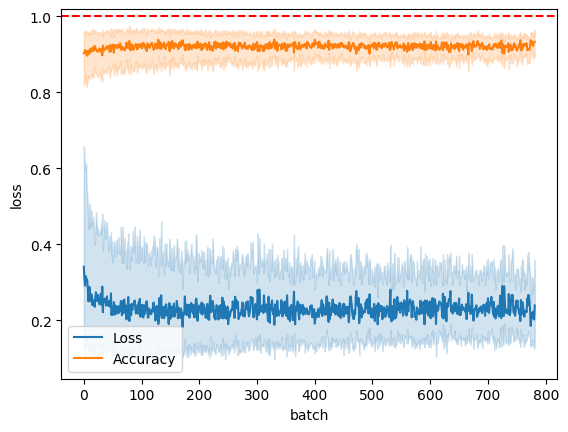

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Tlist_df = pd.DataFrame(Tlist)
line = sns.lineplot(x="batch", y="loss", data=Tlist_df, label="Loss")
line = sns.lineplot(x="batch", y="accuracy", data=Tlist_df, label="Accuracy")
target_y = 1
line.axhline(y=target_y,color = 'red',linestyle='--')

Total Train time is: 1121.452612338


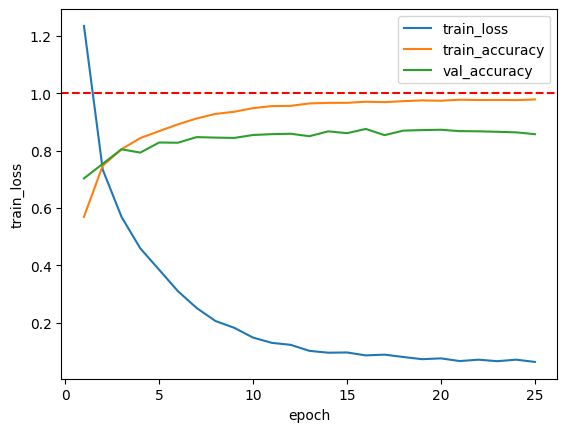

In [38]:
history_df = pd.DataFrame(history)
line = sns.lineplot(x="epoch", y="train_loss", data=history_df, label="train_loss")
line = sns.lineplot(x="epoch", y="train_accuracy", data=history_df,label="train_accuracy")
line = sns.lineplot(x="epoch", y="val_acc", data=history_df,label="val_accuracy")
target_y = 1
line.axhline(y=target_y,color = 'red',linestyle='--')
Timecostlist = Timecost(Timecostlist,method,history_df.iloc[-1]['train_time'],history_df.iloc[-1]['val_acc'],history_df.iloc[-1]['val_loss'])
print('Total Train time is:',history_df.iloc[-1]['train_time'])

From training record,find in some batch exit accuracy attach to 1, which means model have overfiting problem.

### 2) Add dropout function

#### Change Code Part

In [39]:
def conv_block_AD(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.ReLU(inplace=True),
              nn.BatchNorm2d(out_channels), 
              nn.Dropout(0.2),
              ]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9_AD(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block_AD(in_channels, 64)
        self.conv2 = conv_block_AD(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block_AD(128, 128), conv_block_AD(128, 128))
        
        self.conv3 = conv_block_AD(128, 256, pool=True)
        self.conv4 = conv_block_AD(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block_AD(512, 512), conv_block_AD(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [40]:
resnet9_AD = ResNet9_AD(3,10).to(device)
resnet9_AD

ResNet9_AD(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [41]:
summary(resnet9_AD, input_size=(64, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet9_AD                               [64, 10]                  --
├─Sequential: 1-1                        [64, 64, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 64, 32, 32]          1,792
│    └─ReLU: 2-2                         [64, 64, 32, 32]          --
│    └─BatchNorm2d: 2-3                  [64, 64, 32, 32]          128
│    └─Dropout: 2-4                      [64, 64, 32, 32]          --
├─Sequential: 1-2                        [64, 128, 16, 16]         --
│    └─Conv2d: 2-5                       [64, 128, 32, 32]         73,856
│    └─ReLU: 2-6                         [64, 128, 32, 32]         --
│    └─BatchNorm2d: 2-7                  [64, 128, 32, 32]         256
│    └─Dropout: 2-8                      [64, 128, 32, 32]         --
│    └─MaxPool2d: 2-9                    [64, 128, 16, 16]         --
├─Sequential: 1-3                        [64, 128, 16, 16]         --
│    └

In [42]:
resnet9_AD = ResNet9_AD(3,10).to(device)
method = 'ResNet9_ADD_DropOut'
model = to_device(resnet9_AD,device)
optimizer = optim.Adam(resnet9_AD.parameters(), lr=1e-2)
opt_func = torch.optim.Adam(model.parameters(),amsgrad=True
                            ,weight_decay=weight_decay)

#### Evaluation Result

In [43]:
history2,Tlist2 = fit_one_cycle(method,epochs,model,train_dl,test_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Train Epoch: 1 [0/782 (0%)]	Loss: 4.119089, Accuracy: 0.0938
Train Epoch: 1 [60/782 (8%)]	Loss: 2.301187, Accuracy: 0.3125
Train Epoch: 1 [120/782 (15%)]	Loss: 2.113654, Accuracy: 0.3750
Train Epoch: 1 [180/782 (23%)]	Loss: 1.656616, Accuracy: 0.4219
Train Epoch: 1 [240/782 (31%)]	Loss: 1.742953, Accuracy: 0.4062
Train Epoch: 1 [300/782 (38%)]	Loss: 1.349676, Accuracy: 0.5312
Train Epoch: 1 [360/782 (46%)]	Loss: 1.484412, Accuracy: 0.5156
Train Epoch: 1 [420/782 (54%)]	Loss: 1.243562, Accuracy: 0.5938
Train Epoch: 1 [480/782 (61%)]	Loss: 1.131621, Accuracy: 0.6250
Train Epoch: 1 [540/782 (69%)]	Loss: 1.294701, Accuracy: 0.5938
Train Epoch: 1 [600/782 (77%)]	Loss: 1.126593, Accuracy: 0.5938
Train Epoch: 1 [660/782 (84%)]	Loss: 0.872237, Accuracy: 0.6875
Train Epoch: 1 [720/782 (92%)]	Loss: 1.152276, Accuracy: 0.5781
Train Epoch: 1 [780/782 (100%)]	Loss: 0.962910, Accuracy: 0.6406
train_time: 46.241241830000035
Epoch [1], train_loss: 1.4976, train_acc: 0.5053, val_loss: 1.1469, val_acc: 

#### Visualization Result

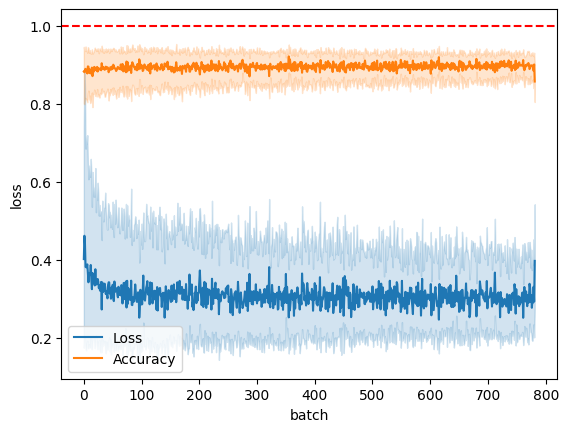

In [44]:
Tlist2_df = pd.DataFrame(Tlist2)
line = sns.lineplot(x="batch", y="loss", data=Tlist2_df, label="Loss")
line = sns.lineplot(x="batch", y="accuracy", data=Tlist2_df, label="Accuracy")

target_y = 1
line.axhline(y=target_y,color = 'red',linestyle='--')

Total Train time is: 1140.6153734650002


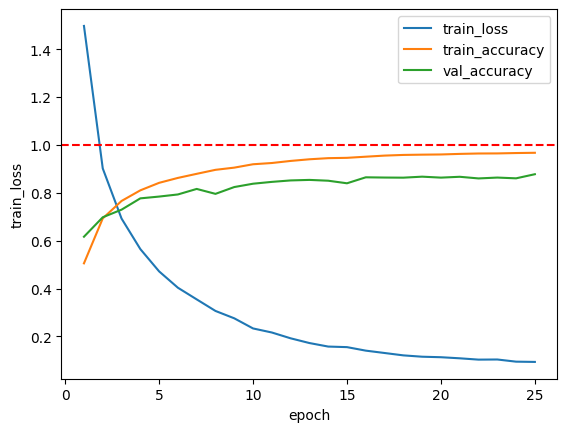

In [45]:
history2_df = pd.DataFrame(history2)
line = sns.lineplot(x="epoch", y="train_loss", data=history2_df, label="train_loss")
line = sns.lineplot(x="epoch", y="train_accuracy", data=history2_df,label="train_accuracy")
line = sns.lineplot(x="epoch", y="val_acc", data=history2_df,label="val_accuracy")
target_y = 1
line.axhline(y=target_y,color = 'red',linestyle='--')
Timecostlist = Timecost(Timecostlist,method,history2_df.iloc[-1]['train_time'],history2_df.iloc[-1]['val_acc'],history2_df.iloc[-1]['val_loss'])
print('Total Train time is:',history2_df.iloc[-1]['train_time'])

### Partial Summary

From present, it seems no obviously decrease from train time side, decide to dipose input picture first to accelerate our training speed. Can we max pooling the imgae first? And then send those disposed image for ResNet-9 model training?

According to literature, the fact that the majority of c culations in a neural network can be represented as a sequence of matrix operations has important computational implications for deep learning(Kelleher,John D.. Deep Learning, MIT Press,2019.Chapter 3 - Neural NetWorks: The building blocks of deep learning, Accelerating Neural Network Training Using GPUs(P97))

Based on this, decide to use max pooling to dispose data before loading, to reduce the computational complexity

### 3) Disposed input data

In [46]:
pool_size = 2 
pooled_train_set = []
pooled_val_set = []

for i,data in enumerate(trainset,0):
    images,labels = data
    pooled_images=torch.nn.functional.max_pool2d(images,pool_size)
    pooled_train_set.append((pooled_images,labels))

for i,data in enumerate(valset,0):
    images,labels = data
    pooled_images=torch.nn.functional.max_pool2d(images,pool_size)
    pooled_val_set.append((pooled_images,labels))

input_size = trainset[0][0].shape[-2:]
output_size = [int(input_size[0]/pool_size),int(input_size[1]/pool_size)]
Original_input = len(trainset)+len(valset)
total_input = len(pooled_train_set) + len(pooled_val_set)
print('original_input：',Original_input)
print("Max_pool_input:", total_input)
print('input_size',input_size,'output_size',output_size)
pl_train_loader = DataLoader(pooled_train_set,batch_size=64,shuffle=True)
pl_val_loader = DataLoader(pooled_val_set,batch_size=64,shuffle=False)

original_input： 60000
Max_pool_input: 60000
input_size torch.Size([32, 32]) output_size [16, 16]


In [47]:
pl_train_dl = DeviceDataLoader(pl_train_loader,device)
pl_val_dl = DeviceDataLoader(pl_val_loader,device)

In [48]:
resnet9_AD = ResNet9_AD(3,10).to(device)

In [49]:
summary(resnet9_AD, input_size=(64, 3, 16, 16))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet9_AD                               [64, 10]                  --
├─Sequential: 1-1                        [64, 64, 16, 16]          --
│    └─Conv2d: 2-1                       [64, 64, 16, 16]          1,792
│    └─ReLU: 2-2                         [64, 64, 16, 16]          --
│    └─BatchNorm2d: 2-3                  [64, 64, 16, 16]          128
│    └─Dropout: 2-4                      [64, 64, 16, 16]          --
├─Sequential: 1-2                        [64, 128, 8, 8]           --
│    └─Conv2d: 2-5                       [64, 128, 16, 16]         73,856
│    └─ReLU: 2-6                         [64, 128, 16, 16]         --
│    └─BatchNorm2d: 2-7                  [64, 128, 16, 16]         256
│    └─Dropout: 2-8                      [64, 128, 16, 16]         --
│    └─MaxPool2d: 2-9                    [64, 128, 8, 8]           --
├─Sequential: 1-3                        [64, 128, 8, 8]           --
│    └

#### Evaluation Result

In [50]:
method = 'MPDS_ResNet_AD'
optimizer = optim.Adam(resnet9_AD.parameters(), lr=1e-2)
model = to_device(ResNet9_AD(3, 10), device)
opt_func = torch.optim.Adam(model.parameters(),amsgrad=True
                            ,weight_decay=weight_decay)
history3,Tlist3 = fit_one_cycle(method,epochs,model,pl_train_dl,pl_val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Train Epoch: 1 [0/782 (0%)]	Loss: 4.338716, Accuracy: 0.0469
Train Epoch: 1 [60/782 (8%)]	Loss: 1.953693, Accuracy: 0.3281
Train Epoch: 1 [120/782 (15%)]	Loss: 2.116004, Accuracy: 0.3906
Train Epoch: 1 [180/782 (23%)]	Loss: 1.529334, Accuracy: 0.4531
Train Epoch: 1 [240/782 (31%)]	Loss: 1.512250, Accuracy: 0.3906
Train Epoch: 1 [300/782 (38%)]	Loss: 1.561722, Accuracy: 0.4375
Train Epoch: 1 [360/782 (46%)]	Loss: 1.638334, Accuracy: 0.4844
Train Epoch: 1 [420/782 (54%)]	Loss: 1.632894, Accuracy: 0.3750
Train Epoch: 1 [480/782 (61%)]	Loss: 1.218019, Accuracy: 0.5938
Train Epoch: 1 [540/782 (69%)]	Loss: 1.599341, Accuracy: 0.5000
Train Epoch: 1 [600/782 (77%)]	Loss: 1.107845, Accuracy: 0.6250
Train Epoch: 1 [660/782 (84%)]	Loss: 0.975385, Accuracy: 0.6406
Train Epoch: 1 [720/782 (92%)]	Loss: 1.065083, Accuracy: 0.6094
Train Epoch: 1 [780/782 (100%)]	Loss: 0.984559, Accuracy: 0.5938
train_time: 15.038804004999747
Epoch [1], train_loss: 1.5951, train_acc: 0.4806, val_loss: 5.3894, val_acc: 

#### Visualization Result

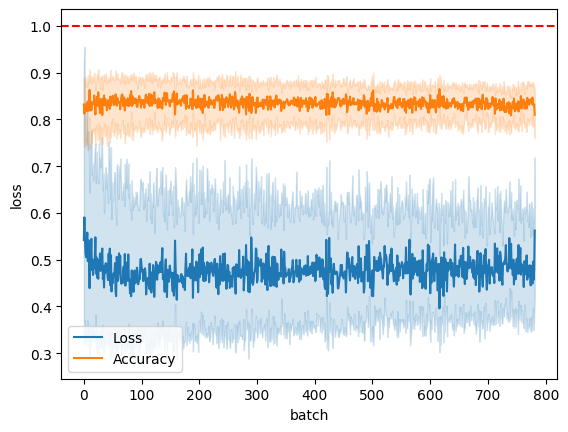

In [51]:
Tlist3_df = pd.DataFrame(Tlist3)
line = sns.lineplot(x="batch", y="loss", data=Tlist3_df, label="Loss")
line = sns.lineplot(x="batch", y="accuracy", data=Tlist3_df, label="Accuracy")

target_y = 1
line.axhline(y=target_y,color = 'red',linestyle='--')

Total Train time is: 375.658239818998


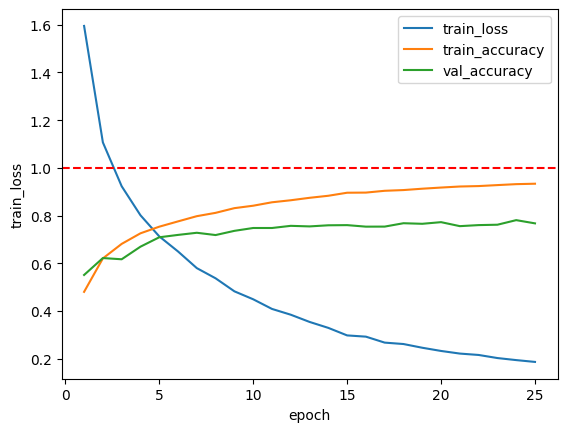

In [52]:
history3_df = pd.DataFrame(history3)
line = sns.lineplot(x="epoch", y="train_loss", data=history3_df, label="train_loss")
line = sns.lineplot(x="epoch", y="train_accuracy", data=history3_df,label="train_accuracy")
line = sns.lineplot(x="epoch", y="val_acc", data=history3_df,label="val_accuracy")
target_y = 1
line.axhline(y=target_y,color = 'red',linestyle='--')
Timecostlist = Timecost(Timecostlist,method,history3_df.iloc[-1]['train_time'],history3_df.iloc[-1]['val_acc'],history3_df.iloc[-1]['val_loss'])
print('Total Train time is:',history3_df.iloc[-1]['train_time'])

### 4) Avgpooling

In [53]:
pool_size = 2 
pooled_train_set = []
pooled_val_set = []

for i,data in enumerate(trainset,0):
    images,labels = data
    pooled_images=torch.nn.functional.avg_pool2d(images,pool_size)
    pooled_train_set.append((pooled_images,labels))

for i,data in enumerate(valset,0):
    images,labels = data
    pooled_images=torch.nn.functional.avg_pool2d(images,pool_size)
    pooled_val_set.append((pooled_images,labels))

avpl_train_loader = torch.utils.data.DataLoader(pooled_train_set,batch_size=64,shuffle=True)
avpl_val_loader = torch.utils.data.DataLoader(pooled_val_set,batch_size=64,shuffle=False)

In [54]:
avpl_train_dl = DeviceDataLoader(pl_train_loader,device)
avpl_val_dl = DeviceDataLoader(pl_val_loader,device)

#### Evaluation Result

In [55]:
resnet9_AD = ResNet9_AD(3,10).to(device)

In [56]:
method = 'AVPDS_ResNet_AD'
optimizer = optim.Adam(resnet9_AD.parameters(), lr=1e-2)
model = to_device(ResNet9_AD(3, 10), device)
opt_func = torch.optim.Adam(model.parameters(),amsgrad=True
                            ,weight_decay=weight_decay)
history4,Tlist4 = fit_one_cycle(method,epochs,model,avpl_train_dl,avpl_val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Train Epoch: 1 [0/782 (0%)]	Loss: 3.915856, Accuracy: 0.0156
Train Epoch: 1 [60/782 (8%)]	Loss: 2.128499, Accuracy: 0.3125
Train Epoch: 1 [120/782 (15%)]	Loss: 1.739746, Accuracy: 0.5000
Train Epoch: 1 [180/782 (23%)]	Loss: 1.497342, Accuracy: 0.4531
Train Epoch: 1 [240/782 (31%)]	Loss: 1.815084, Accuracy: 0.4375
Train Epoch: 1 [300/782 (38%)]	Loss: 1.521766, Accuracy: 0.4844
Train Epoch: 1 [360/782 (46%)]	Loss: 1.353063, Accuracy: 0.5156
Train Epoch: 1 [420/782 (54%)]	Loss: 1.719119, Accuracy: 0.4219
Train Epoch: 1 [480/782 (61%)]	Loss: 1.242823, Accuracy: 0.5312
Train Epoch: 1 [540/782 (69%)]	Loss: 1.303214, Accuracy: 0.5781
Train Epoch: 1 [600/782 (77%)]	Loss: 1.420231, Accuracy: 0.5469
Train Epoch: 1 [660/782 (84%)]	Loss: 1.231953, Accuracy: 0.5156
Train Epoch: 1 [720/782 (92%)]	Loss: 1.271880, Accuracy: 0.5000
Train Epoch: 1 [780/782 (100%)]	Loss: 1.344495, Accuracy: 0.5625
train_time: 14.930533349000143
Epoch [1], train_loss: 1.5916, train_acc: 0.4722, val_loss: 1.4267, val_acc: 

#### Visualization Result

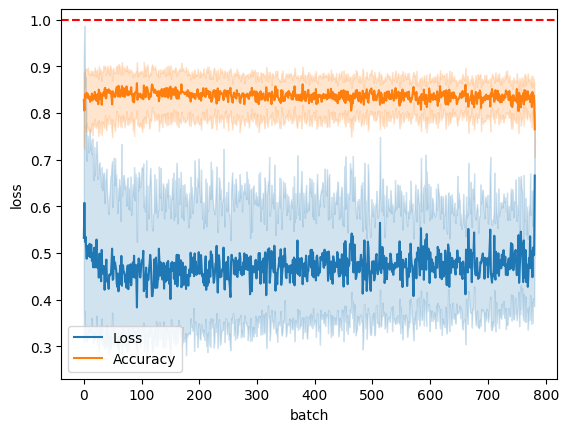

In [57]:
Tlist4_df = pd.DataFrame(Tlist4)
line = sns.lineplot(x="batch", y="loss", data=Tlist4_df, label="Loss")
line = sns.lineplot(x="batch", y="accuracy", data=Tlist4_df, label="Accuracy")

target_y = 1
line.axhline(y=target_y,color = 'red',linestyle='--')

Total Train time is: 374.0605999130016


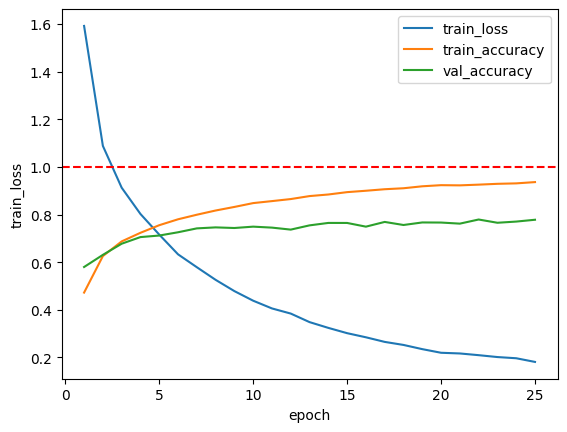

In [58]:
history4_df = pd.DataFrame(history4)
line = sns.lineplot(x="epoch", y="train_loss", data=history4_df, label="train_loss")
line = sns.lineplot(x="epoch", y="train_accuracy", data=history4_df,label="train_accuracy")
line = sns.lineplot(x="epoch", y="val_acc", data=history4_df,label="val_accuracy")
target_y = 1
line.axhline(y=target_y,color = 'red',linestyle='--')
print('Total Train time is:',history4_df.iloc[-1]['train_time'])
Timecostlist = Timecost(Timecostlist,method,history4_df.iloc[-1]['train_time'],history4_df.iloc[-1]['val_acc'],history4_df.iloc[-1]['val_loss'])

### 5) Moving Max pooling
(https://myrtle.ai/how-to-train-your-resnet-8-bag-of-tricks/)

#### Change Code Part

In [59]:
def conv_block_MP(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.ReLU(inplace=True),
              nn.BatchNorm2d(out_channels),
              nn.Dropout(0.2), 
              ]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9_MovingPooling(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block_MP(in_channels, 64)
        self.conv2 = conv_block_MP(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block_MP(128, 128), conv_block_MP(128, 128))
        
        self.conv3 = conv_block_MP(128, 256, pool=True)
        self.conv4 = conv_block_MP(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block_MP(512, 512), conv_block_MP(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

#### Evaluation

In [60]:
resnet9_MP = ResNet9_MovingPooling(3,10).to(device)

In [61]:
summary(resnet9_MP, input_size=(64, 3, 16, 16))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet9_MovingPooling                    [64, 10]                  --
├─Sequential: 1-1                        [64, 64, 16, 16]          --
│    └─Conv2d: 2-1                       [64, 64, 16, 16]          1,792
│    └─ReLU: 2-2                         [64, 64, 16, 16]          --
│    └─BatchNorm2d: 2-3                  [64, 64, 16, 16]          128
│    └─Dropout: 2-4                      [64, 64, 16, 16]          --
├─Sequential: 1-2                        [64, 128, 8, 8]           --
│    └─Conv2d: 2-5                       [64, 128, 16, 16]         73,856
│    └─ReLU: 2-6                         [64, 128, 16, 16]         --
│    └─BatchNorm2d: 2-7                  [64, 128, 16, 16]         256
│    └─Dropout: 2-8                      [64, 128, 16, 16]         --
│    └─MaxPool2d: 2-9                    [64, 128, 8, 8]           --
├─Sequential: 1-3                        [64, 128, 8, 8]           --
│    └

In [62]:
resnet9_MP = ResNet9_MovingPooling(3,10).to(device)
method = 'MovingPooling'
model = to_device(resnet9_MP,device)
optimizer = optim.Adam(resnet9_MP.parameters(), lr=1e-2)
opt_func = torch.optim.Adam(model.parameters(),amsgrad=True
                            ,weight_decay=weight_decay)

In [63]:
history5,Tlist5 = fit_one_cycle(method,epochs,model,avpl_train_dl,avpl_val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Train Epoch: 1 [0/782 (0%)]	Loss: 4.170028, Accuracy: 0.0625
Train Epoch: 1 [60/782 (8%)]	Loss: 2.156645, Accuracy: 0.2500
Train Epoch: 1 [120/782 (15%)]	Loss: 2.042839, Accuracy: 0.4062
Train Epoch: 1 [180/782 (23%)]	Loss: 1.901518, Accuracy: 0.4688
Train Epoch: 1 [240/782 (31%)]	Loss: 1.333702, Accuracy: 0.5625
Train Epoch: 1 [300/782 (38%)]	Loss: 1.467855, Accuracy: 0.4375
Train Epoch: 1 [360/782 (46%)]	Loss: 1.477865, Accuracy: 0.5156
Train Epoch: 1 [420/782 (54%)]	Loss: 1.369471, Accuracy: 0.5156
Train Epoch: 1 [480/782 (61%)]	Loss: 1.391626, Accuracy: 0.5156
Train Epoch: 1 [540/782 (69%)]	Loss: 1.399001, Accuracy: 0.5625
Train Epoch: 1 [600/782 (77%)]	Loss: 1.100663, Accuracy: 0.5938
Train Epoch: 1 [660/782 (84%)]	Loss: 1.098537, Accuracy: 0.5781
Train Epoch: 1 [720/782 (92%)]	Loss: 1.390614, Accuracy: 0.4531
Train Epoch: 1 [780/782 (100%)]	Loss: 1.347368, Accuracy: 0.5469
train_time: 14.930530381000153
Epoch [1], train_loss: 1.5643, train_acc: 0.4719, val_loss: 1.2161, val_acc: 

#### Visualization Result

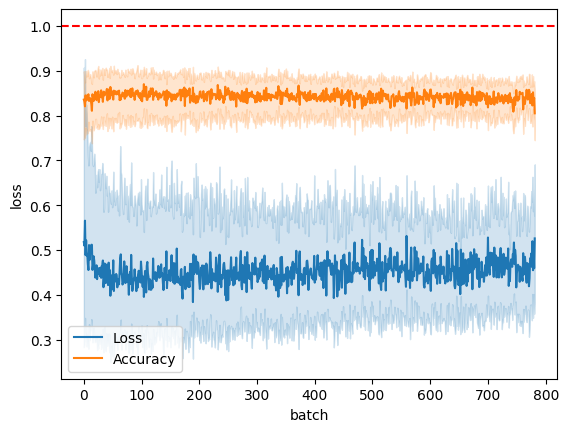

In [64]:
Tlist5_df = pd.DataFrame(Tlist5)
line = sns.lineplot(x="batch", y="loss", data=Tlist5_df, label="Loss")
line = sns.lineplot(x="batch", y="accuracy", data=Tlist5_df, label="Accuracy")

target_y = 1
line.axhline(y=target_y,color = 'red',linestyle='--')

Total Train time is: 373.97843377300023


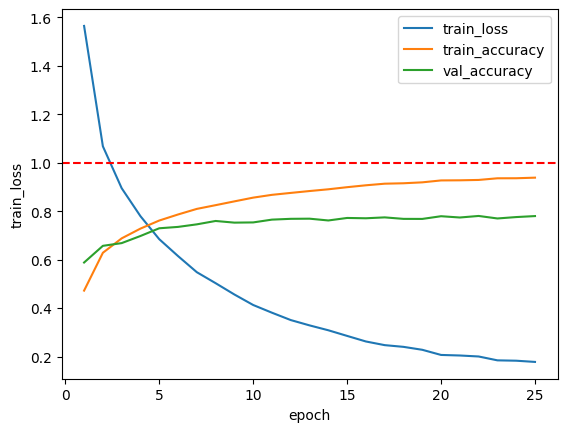

In [65]:
history5_df = pd.DataFrame(history5)
line = sns.lineplot(x="epoch", y="train_loss", data=history5_df, label="train_loss")
line = sns.lineplot(x="epoch", y="train_accuracy", data=history5_df,label="train_accuracy")
line = sns.lineplot(x="epoch", y="val_acc", data=history5_df,label="val_accuracy")
target_y = 1
line.axhline(y=target_y,color = 'red',linestyle='--')
print('Total Train time is:',history5_df.iloc[-1]['train_time'])
Timecostlist = Timecost(Timecostlist,method,history5_df.iloc[-1]['train_time'],history5_df.iloc[-1]['val_acc'],history5_df.iloc[-1]['val_loss'])

# **Summary**

## Visualization Result

In [66]:
Timecostlist_df = pd.DataFrame(Timecostlist)
Timecostlist_df

,method,Totaltime,val_accuracy,val_loss
0,Original State,1121.452612,0.857584,0.574178
1,ResNet9_ADD_DropOut,1140.615373,0.877787,0.566832
2,MPDS_ResNet_AD,375.658240,0.767615,1.029685
3,AVPDS_ResNet_AD,374.060600,0.777966,1.040429
4,MovingPooling,373.978434,0.779558,1.010017


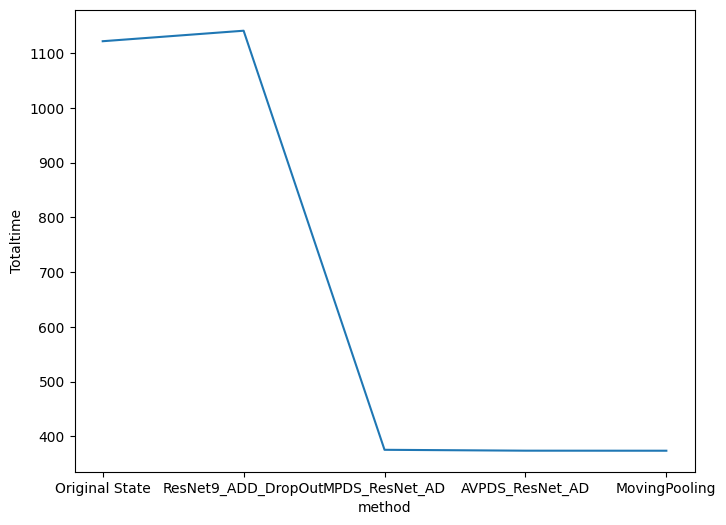

In [67]:
fig = sns.lineplot(x='method',y='Totaltime',data=Timecostlist_df)
fig = plt.gcf()
fig.set_size_inches(8,6)

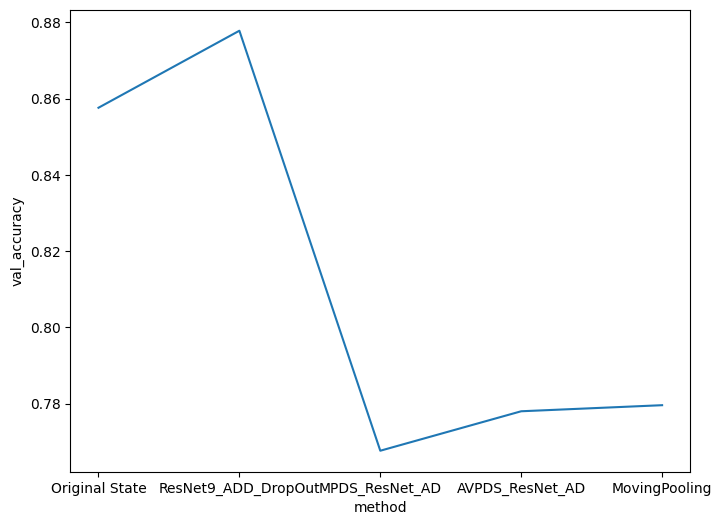

In [68]:
fig2 = sns.lineplot(x='method',y='val_accuracy',data=Timecostlist_df)
fig2 = plt.gcf()
fig2.set_size_inches(8,6)

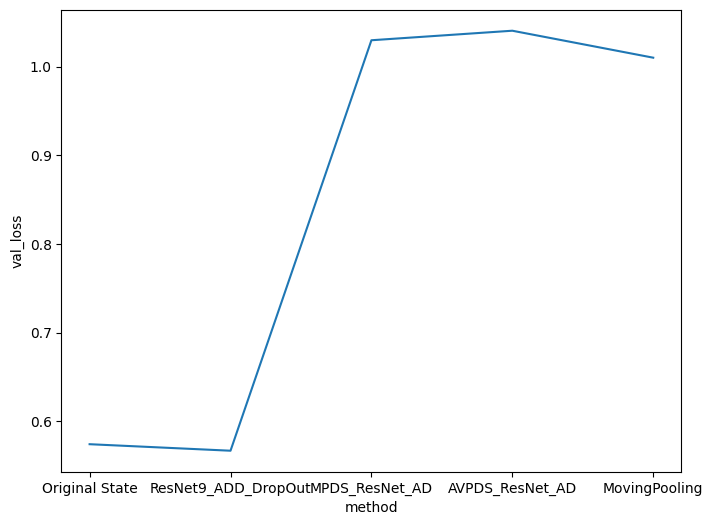

In [69]:
fig3 = sns.lineplot(x='method',y='val_loss',data=Timecostlist_df)
fig2 = plt.gcf()
fig2.set_size_inches(8,6)